In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from fab.utils.plotting import plot_contours, plot_marginal_pair
from experiments.make_flow import make_wrapped_normflow_realnvp
import models.ddpm
import models.mlp
import pdb
from typing import Callable
from tqdm import tqdm
from models.ddpm import GaussianDiffusion, TMLP
from models.mlp import MyMLP, SpectralNormMLP

import math
import os
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import torch

import torch
import torchsde

from functorch import vmap

from torchdiffeq import odeint

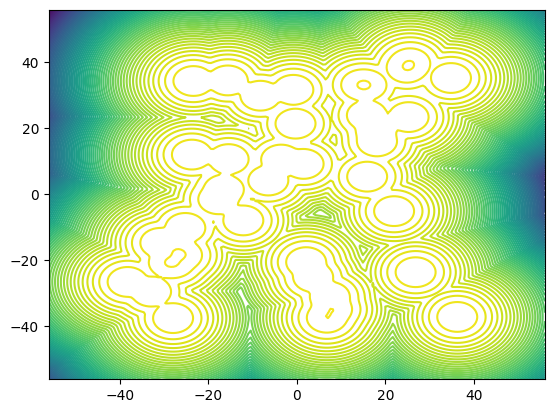

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dim = 2
n_mixes = 40
loc_scaling = 40.0  # scale of the problem (changes how far apart the modes of each Guassian component will be)
log_var_scaling = 1.0  # variance of each Gaussian
seed = 0

if device == "cpu":
    use_gpu = False
else:
    use_gpu = True

torch.manual_seed(0)  # seed of 0 for GMM problem
target = GMM(
    dim=dim,
    n_mixes=n_mixes,
    loc_scaling=loc_scaling,
    log_var_scaling=log_var_scaling,
    use_gpu=use_gpu,
    true_expectation_estimation_n_samples=int(1e5),
)
# plot target
target.to("cpu")
fig, ax = plt.subplots()
plotting_bounds = (-loc_scaling * 1.4, loc_scaling * 1.4)
plot_contours(
    target.log_prob,
    bounds=plotting_bounds,
    n_contour_levels=80,
    ax=ax,
    grid_width_n_points=200,
)
target.to(device)

### Helper functions

In [4]:
def plot_dataset(samples, gen_samples=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    target.to("cpu")
    plot_contours(
        target.log_prob,
        bounds=plotting_bounds,
        ax=axs[0],
        n_contour_levels=50,
        grid_width_n_points=200,
    )

    # plot dataset samples
    plot_marginal_pair(samples, ax=axs[0], bounds=plotting_bounds)
    axs[0].set_title("Buffer")

    if gen_samples is not None:
        plot_contours(
            target.log_prob,
            bounds=plotting_bounds,
            ax=axs[1],
            n_contour_levels=50,
            grid_width_n_points=200,
        )
        # plot generated samples
        plot_marginal_pair(gen_samples, ax=axs[1], bounds=plotting_bounds)
        axs[1].set_title("Generated samples")

    else:
        # delete subplot
        fig.delaxes(axs[1])

    target.to(device)
    plt.show()
    return [fig]

In [5]:
from abc import ABC, abstractmethod


class NoiseSchedule(ABC):
    @abstractmethod
    def g(t):
        # Returns g(t)
        pass

    @abstractmethod
    def h(t):
        # Returns \int_0^t g(t)^2 dt
        pass


class LinearNoiseSchedule(NoiseSchedule):
    def __init__(self, beta, norm_factor=1.0):
        self.beta = beta / norm_factor
        self.norm_factor = norm_factor

    def g(self, t):
        return np.sqrt(self.beta)

    def h(self, t):
        return self.beta * t


class GeometricNoiseSchedule(NoiseSchedule):
    def __init__(self, sigma_min, sigma_max, norm_factor=1.0):
        self.sigma_min = sigma_min / norm_factor
        self.sigma_max = sigma_max / norm_factor
        self.sigma_diff = self.sigma_max / self.sigma_min

        self.norm_factor = norm_factor

    def g(self, t):
        # Let sigma_d = sigma_max / sigma_min
        # Then g(t) = sigma_min * sigma_d^t * sqrt{2 * log(sigma_d)}
        # See Eq 192 in https://arxiv.org/pdf/2206.00364.pdf
        return (
            self.sigma_min
            * (self.sigma_diff**t)
            * ((2 * np.log(self.sigma_diff)) ** 0.5)
        )

    def h(self, t):
        # Let sigma_d = sigma_max / sigma_min
        # Then h(t) = \int_0^t g(z)^2 dz = sigma_min * sqrt{sigma_d^{2t} - 1}
        # see Eq 199 in https://arxiv.org/pdf/2206.00364.pdf
        return (self.sigma_min * (((self.sigma_diff ** (2 * t)) - 1) ** 0.5)) ** 2

### Functions

In [6]:
def true_Rt(x, t, noise_schedule, var_exploding=True):
    h_t = noise_schedule.h(t).to(device)
    target.convolve(h_t, t, var_exploding=var_exploding)
    energy = target.log_prob(x)
    target.reset()
    return energy


def true_grad_Rt(x, t, noise_schedule, var_exploding=True):
    with torch.enable_grad():
        samples_energy = true_Rt(x, t, noise_schedule, var_exploding=var_exploding)
    true_scores = torch.autograd.grad(samples_energy.sum(), x, create_graph=True)[0]  
    return true_scores


# calculate the log expectation of the reward
def log_E_R(_x, _t, noise_schedule, num_mc_samples):
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)

    h_t = noise_schedule.h(repeated_t).unsqueeze(1)
    samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t**0.5)

    log_rewards = target.log_prob(samples) 
    # log_rewards = torch.clamp(log_rewards, min=-40)
    mask = log_rewards < -1e4
    log_rewards = log_rewards * ~mask + - 1e-8 * mask

    # return log_rewards
    # return log_rewards - np.log(num_mc_samples)
    return torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)


# calculate the log expectation of the reward
def E_R(_x, _t, noise_schedule, num_mc_samples):
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)

    h_t = noise_schedule.h(repeated_t).unsqueeze(1)
    samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t**0.5)

    R = target.log_prob(samples).exp()
    E_R = R.mean(dim=0)
    return E_R


def clip_norm(max_norm: float, callee_method: Callable):
    def fxn(*args, **kwargs):
        output = callee_method(*args, **kwargs)

        norm = torch.linalg.vector_norm(est_scores_n, dim=-1)
        clip_coeff = torch.clamp(max_norm / (norm + 1e-6), max=1)

        return output * clip_coeff.unsqueeze(-1)

    return fxn


# def estimate_grad_Rt(x, t, noise_schedule, num_mc_samples=200):
#     if x.ndim == 1:
#         x = x.unsqueeze(0)
#         t = t.unsqueeze(0)

#     grad_fxn = torch.vmap(
#         torch.func.grad(log_E_R),
#         in_dims=(0, 0, None, None),
#         randomness='different'
#     )

#     return grad_fxn(x, t, noise_schedule, num_mc_samples)


def estimate_grad_Rt(x, t, noise_schedule, num_mc_samples=100):
    est_scores_n = torch.func.grad(log_E_R)(x, t, noise_schedule, num_mc_samples)
    return est_scores_n


def covar_trace(scores):
    vmapped_cov = torch.vmap(torch.cov, in_dims=(0,))
    covs = vmapped_cov(scores.permute(1, 2, 0))

    vmapped_trace = torch.vmap(torch.trace)
    return vmapped_trace(covs)


def get_componentwise_var(
    x0, t, noise_schedule, var_model, num_outer_mc_samples=10, num_inner_mc_samples=10
):
    repeated_x = x0.unsqueeze(0).repeat_interleave(num_outer_mc_samples, dim=0)
    repeated_t = t.unsqueeze(0).repeat_interleave(num_outer_mc_samples, dim=0)

    repeated_samples = repeated_x + (
        torch.randn_like(repeated_x) * noise_schedule.h(t).sqrt().unsqueeze(1)
    )

    vmapped_est = torch.vmap(
        estimate_grad_Rt, in_dims=(0, 0, None, None, None), randomness="different"
    )

    est_score = vmapped_est(
        repeated_samples, repeated_t, noise_schedule, var_model, num_inner_mc_samples
    )

    orig_shape = copy.deepcopy(repeated_samples.shape[:2])
    baseline = var_model(repeated_x.flatten(0, 1), repeated_t.flatten(0, 1))

    okay_baseline = est_score.mean(dim=0)
    baseline = baseline.reshape(*orig_shape, -1)

    adjusted_score = est_score - baseline + baseline.mean(dim=0).mean(dim=0)
    covar_traces = covar_trace(adjusted_score)
    return covar_traces.mean()

    # okay_adjusted_score = est_score - okay_baseline

    # import pdb; pdb.set_trace()
    # loss = adjusted_score.pow(2).mean()
    # loss = adjusted_score.var(dim=0).mean()
    # var = est_score.var(dim=0).mean()

    # return loss, okay_adjusted_score.var(dim=0).mean()


def get_covar_mtx(x0, t, noise_schedule, var_model, num_mc_samples=200):
    pass

### Tests

In [7]:
from math import sqrt

# noise_schedule = GeometricNoiseSchedule(sqrt(0.01), sqrt(1000), 1)
noise_schedule = LinearNoiseSchedule(1000)

# noise_schedule = GeometricNoiseSchedule(0.01, 100, 1)

In [8]:
num_samples = 1000
with torch.no_grad():
    target.convolve(torch.tensor(noise_schedule.h(1), device=torch.device("cpu")), 1)
    x1_samples = target.sample((num_samples,))
    target.reset()

In [9]:
normal_samples = torch.randn_like(x1_samples) * torch.sqrt(
    torch.tensor(noise_schedule.h(1), device=torch.device("cpu"))
)

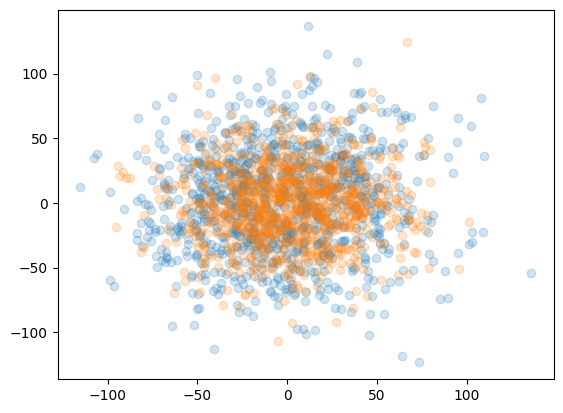

In [10]:
plt.scatter(x1_samples[:, 0].cpu(), x1_samples[:, 1].cpu(), alpha=0.2)
plt.scatter(normal_samples[:, 0].cpu(), normal_samples[:, 1].cpu(), alpha=0.2)

### Variance Tests

$$x_t = x + \epsilon^f \sigma(t)$$

$$\mathrm{var}_{\epsilon^f, [\epsilon_i^b]_{i=1:m}} \nabla_{x_t} \log \sum_{i=1}^m{[R(x_t + \epsilon^b_i  \sigma(t))]}$$

In [11]:
def calculate_bias_variance(x0):
    times = torch.linspace(0, 1, 100, device=device)
    f_xt = []
    true_f_xt = []
    eps = torch.randn_like(x0)
    num_replicates = 512

    for t in times:
        h_t = noise_schedule.h(t).unsqueeze(0)
        # noisy sample: x(t)
        x_t = (x0 + sqrt(h_t) * eps).repeat(num_replicates, 1)
        f_xt.append(
            torch.vmap(estimate_grad_Rt, in_dims=(0, None, None), randomness="different")(
                x_t, t, noise_schedule, num_mc_samples=100)
        )

        # true_f_xt.append(true_grad_Rt(x_t, t, noise_schedule))
    f_xt = torch.stack(f_xt, dim=0)
    # true_f_xt = torch.stack(true_f_xt, dim=0)
    return f_xt, true_f_xt

In [ ]:
num_points = 128
x0 = target.sample((num_points,))
f_xt_all, true_f_xt = torch.vmap(calculate_bias_variance, in_dims=(0,), randomness="different")(x0)

In [ ]:
f_xt_all.shape

torch.Size([128, 100, 512, 2])

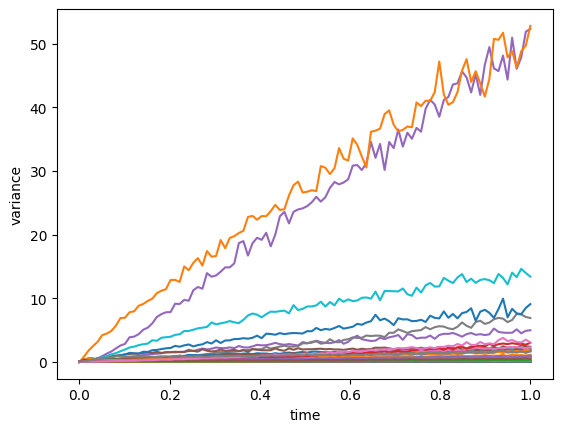

In [140]:
vars_9 = []
for i in range(0, num_points):
    f_xt = f_xt_all[i]
    cov = torch.vmap(torch.cov)(f_xt.permute(0, 2, 1))
    var = torch.vmap(torch.trace)(cov).detach()
    vars_9.append(var[-2])

    times = torch.linspace(0, 1, 100, device=device)
    plt.plot(times.cpu(), var.cpu())
    plt.xlabel("time")
    plt.ylabel("variance")
vars_9 = torch.stack(vars_9).cpu()

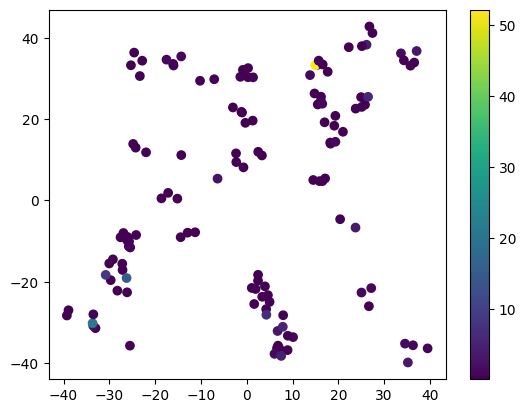

In [ ]:
plt.scatter(x0[:, 0].cpu(), x0[:, 1].cpu(), c=vars_9[:])
plt.colorbar()

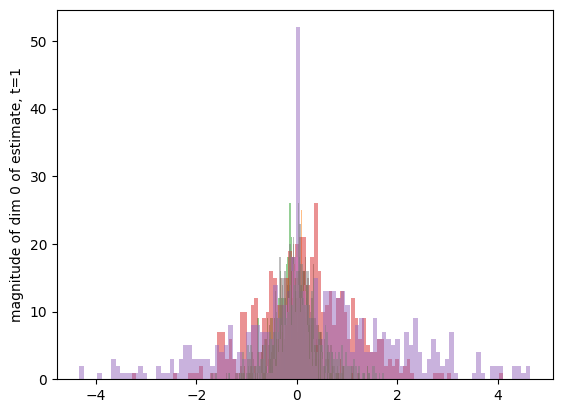

In [ ]:
for i in range(0, 128, 16):
    f_xt = f_xt_all[i]
    cov = torch.vmap(torch.cov)(f_xt.permute(0, 2, 1))
    var = torch.vmap(torch.trace)(cov).detach()
    

    times = torch.linspace(0, 1, 100, device=device)
    plt.hist(f_xt[-1,:,0].detach().cpu(), bins=100, alpha=0.5)
    plt.ylabel("magnitude of dim 0 of estimate, t=1")


$$\text{var}_{[\epsilon^b_i]_{i=1:n}} \nabla_x \log \sum_i{[R(x_t + \epsilon^b_i  \sigma(t))]}$$

In [11]:
import random

def compute_bias_variance(num_mc_samples=100, num_points = 512):
    x0 = target.sample((num_points,))
    x0.requires_grad = True
    times = torch.linspace(0, 1, 100, device=device)
    # times = torch.tensor([0.01], device=device)

    f_xt = []
    true_f_xt = []

    # eps = torch.ones_like(x0)
    eps = torch.randn_like(x0)

    num_replicates = 256

    for t in times:
        # noisy sample: x(t)
        x_t = (x0 + sqrt(noise_schedule.h(t)) * eps)
        x_t_repeated = x_t.unsqueeze(1).repeat(1, num_replicates, 1).reshape(-1, 2)

        with torch.no_grad():
            f_xt.append(
                torch.vmap(estimate_grad_Rt, in_dims=(0, None, None), randomness="different")(
                    x_t_repeated, t, noise_schedule, num_mc_samples=num_mc_samples
                ).reshape(num_points, num_replicates, 2)
            )
        true_f_xt.append(true_grad_Rt(x_t, t, noise_schedule))
        # f_xt.append(torch.vmap(log_E_R, in_dims=(0, None, None), randomness="different")(x_t, t, noise_schedule, num_mc_samples=100))

    f_xt = torch.stack(f_xt, dim=0)
    true_f_xt = torch.stack(true_f_xt, dim=0)
    return f_xt, true_f_xt

In [12]:
num_points = 512
times = torch.linspace(0, 1, 100, device=device)

In [13]:
def compute_var(f):
    cov = torch.vmap(torch.cov)(f)
    var = torch.vmap(torch.trace)(cov).detach()/num_points
    return var

In [45]:
num_points = 512
times = torch.linspace(0, 1, 100, device=device)

mc_samples = [1, 10, 50, 100, 500, 1100, 1500, 2000, 2500]

num_reps = 10

mses_reps = []
    
for i in range(num_reps):
    print(i)
    biases = []
    covs = []
    mses = []
    for num_mc_samples in mc_samples:
        # if num_mc_samples ==500:
        #     num_points = 64
        if num_mc_samples >=500:
            num_points = 32
        f_xt, true_f_xt = compute_bias_variance(num_mc_samples, num_points)

        # # calculate covariance
        # f_xt_norm = torch.linalg.vector_norm(f_xt, dim=-1)
        # f_xt_dim0 = f_xt[:,:,:,0]
        # f_xt_dim1 = f_xt[:,:,:,1]
        # cov_norm = compute_var(f_xt_norm)
        # cov_dim0 = compute_var(f_xt_dim0)
        # cov_dim1 = compute_var(f_xt_dim1)

        mse = ((f_xt- true_f_xt.unsqueeze(2))**2).mean(dim=(-1, -2, -3)).detach()
        # bias = ((f_xt.mean(dim=2) - true_f_xt)**2).mean(dim=(-1, -2)).detach()

        # biases.append(bias)
        # mses.append(mse)
        # covs.append(cov_norm)
        mses.append(mse)
    mses_reps.append(torch.stack(mses, dim=0))
    
mses_reps = torch.stack(mses_reps, dim=0)

0
1
2
3
4
5
6
7
8
9


In [51]:
#tensor to pandas
df = pd.DataFrame(mses_reps.mean(dim=-1).cpu().numpy(), columns=mc_samples)
df.index.name = "replicate"

In [53]:
#save to csv
df.to_csv("gmm_mse_v2.csv")

In [91]:
import seaborn as sns
sns.set_theme("paper", font_scale=1.5)

sns.set_style("white")

In [56]:
mses_reps.shape

torch.Size([10, 9, 100])

In [78]:
mses_reps_t_avgd = mses_reps.mean(dim=-1).cpu()

In [22]:
torch.median(mses_reps_t_avgd, dim=1)

torch.return_types.median(
values=tensor([0.0416, 0.0704, 0.0182, 0.1020, 0.1569, 0.0207, 0.0145, 0.1130],
       device='cuda:0'),
indices=tensor([4, 5, 5, 5, 5, 4, 5, 3], device='cuda:0'))

In [79]:
mses_reps_t_avgd = mses_reps_t_avgd.cpu().log()

In [80]:
mses_reps_t_avgd.shape

torch.Size([10, 9])

/home/mila/t/tara.akhoundsadegh/.conda/envs/actinfenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mila/t/tara.akhoundsadegh/.conda/envs/actinfenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


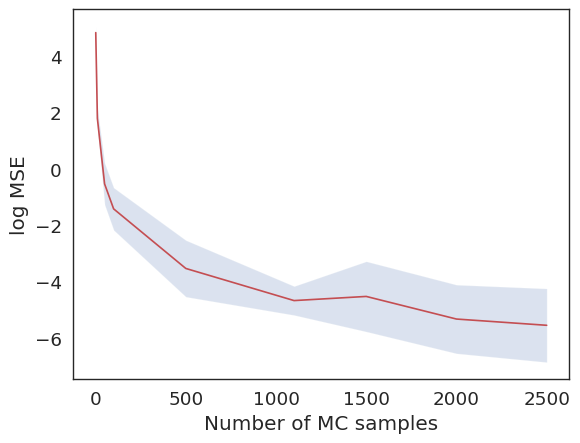

In [94]:
sns.lineplot(x=torch.tensor(mc_samples), y=mses_reps_t_avgd.median(0)[0], c='r')
# plot std
plt.fill_between(
    torch.tensor(mc_samples),
    (mses_reps_t_avgd.median(0)[0].cpu() - mses_reps_t_avgd.std(0).cpu()),
    (mses_reps_t_avgd.median(0)[0].cpu() + mses_reps_t_avgd.std(0).cpu()),
    alpha=0.2,
)
plt.xlabel("Number of MC samples")
plt.ylabel("log MSE")

plt.savefig("gmm_mse.png", bbox_inches="tight")

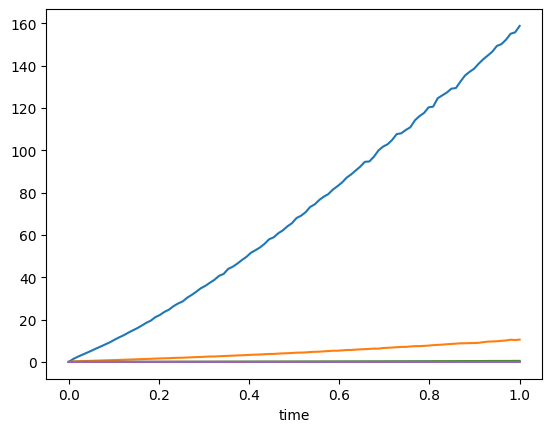

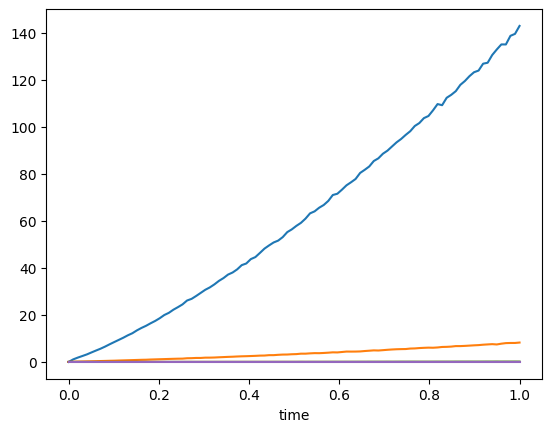

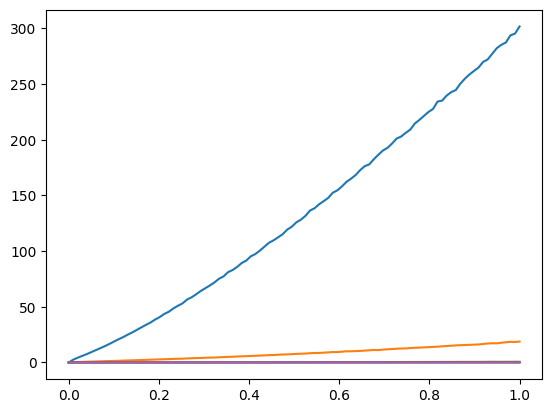

In [69]:
for cov in covs:
    plt.plot(times.cpu(), cov.cpu())
plt.xlabel("time")
plt.show()

for bias in biases:
    plt.plot(times.cpu(), bias.detach().cpu())
plt.xlabel("time")
plt.show()

for i in range(len(mses)):
    plt.plot(times.cpu(), covs[i].detach().cpu()+ biases[i].detach().cpu())

In [57]:
mc_samples = [1, 10, 100, 1000, 2000]

In [80]:
torch.stack(mses).shape

torch.Size([5, 100])

In [108]:
import seaborn as sns

In [ ]:
for i in range(len(mses)):
    plt.plot(mc_samples[i], mses.mean().detach().cpu(), label= str(mc_samples[i]) + " mc samples")
plt.xlabel("time")
plt.ylabel("MSE")
plt.legend()
plt.show()

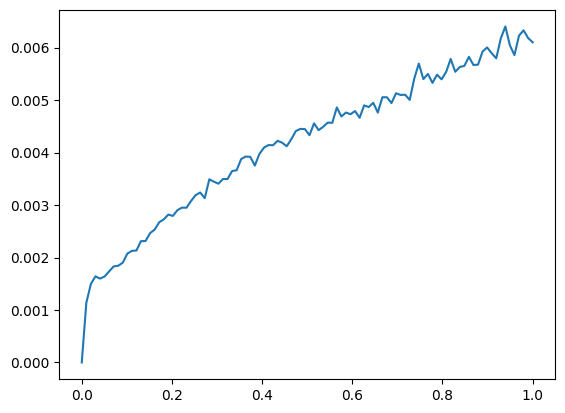

In [88]:
plt.plot(times.cpu(), mses[-1].detach().cpu(), label= str(mc_samples[-1]) + " mc samples")

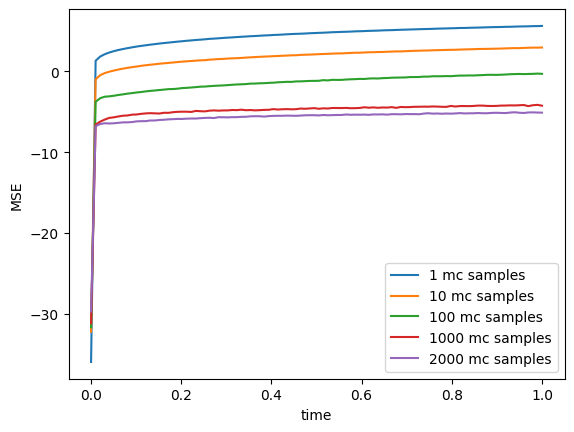

In [86]:
for i in range(len(mses)):
    plt.plot(times.cpu(), mses[i].detach().cpu().log(), label= str(mc_samples[i]) + " mc samples")
plt.xlabel("time")
plt.ylabel("MSE")
plt.legend()
plt.show()

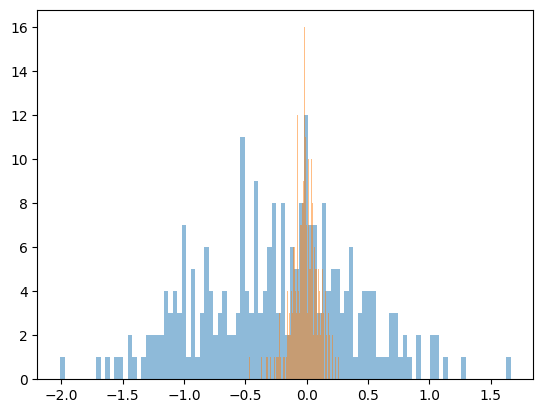

In [118]:
plt.hist(f_xt[3,100,:,0].detach().cpu(), bins=100, alpha=0.5)
plt.hist(f_xt[-1,100,:,0].detach().cpu(), bins=100, alpha=0.5)
plt.show()

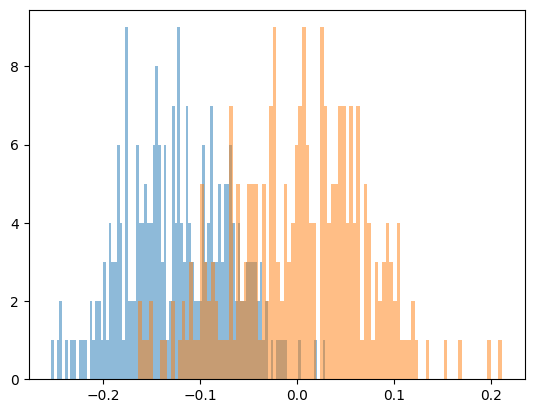

In [105]:
plt.hist(f_xt[3,10,:,0].detach().cpu(), bins=100, alpha=0.5)
plt.hist(f_xt[-1,10,:,0].detach().cpu(), bins=100, alpha=0.5)
plt.show()

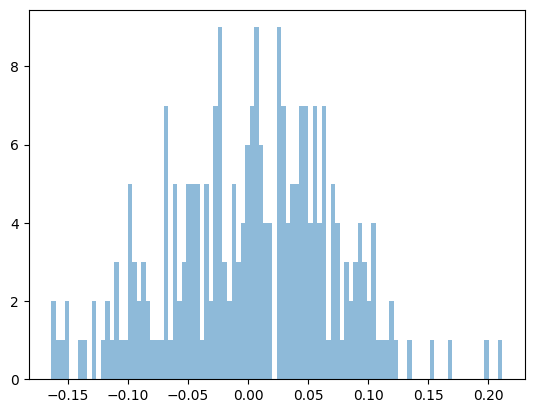

In [94]:
plt.hist(f_xt[-1,10,:,0].detach().cpu(), bins=100, alpha=0.5)
plt.show()

In [ ]:
# calculate covariance
cov = torch.vmap(torch.cov)(f_xt.permute(0, 2, 1))
var = torch.vmap(torch.trace)(cov).detach()

bias = torch.mean(f_xt - true_f_xt, dim=1).sum(dim=-1).detach()

In [ ]:
# plt.plot(times.cpu(), bias.detach().cpu())

Text(0, 0.5, 'variance')

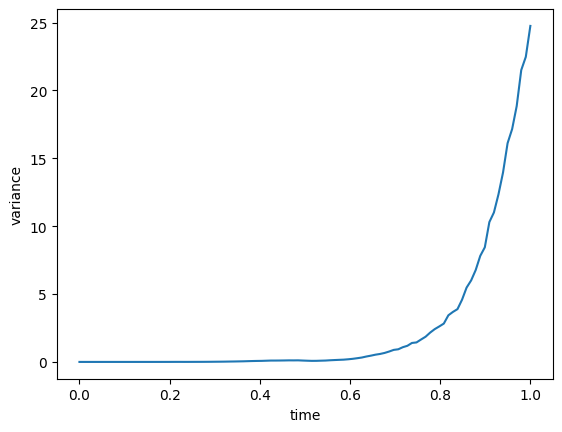

In [ ]:
# plt.plot(times.cpu(), f_xt.var(dim=1).cpu())
times = torch.linspace(0, 1, 100, device=device)
plt.plot(times.cpu(), var.cpu())
plt.xlabel("time")
plt.ylabel("variance")

### Generation

In [ ]:
class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score, noise_schedule):
        super().__init__()
        self.score = score
        self.noise_schedule = noise_schedule
    
    def f(self, t, x):
        with torch.enable_grad():
            if t.dim() == 0:
                # repeat the same time for all points if we have a scalar time
                t = t * torch.ones(x.shape[0]).to(device)
                
            x.requires_grad = True
            # score = self.score(x, 1-t, self.noise_schedule)
            score = torch.vmap(self.score, randomness="different", in_dims=(0,0,None))(x, 1-t, self.noise_schedule)
        return self.g(t)**2 * score 
    
    def g(self, t):
        return self.noise_schedule.g(t.unsqueeze(1))

In [ ]:
def euler_maruyama_step(sde, x, t, dt):
    # Calculate drift and diffusion terms
    drift = sde.f(t, x) * dt

    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones(x.shape[0]).to(device)
    diffusion = sde.g(t) * np.sqrt(dt) * torch.randn_like(x).to(device)

    # Update the state
    x_next = x + drift + diffusion
    return x_next, drift

def integrate_sde(sde, x0, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    pred_v = []
    true_v = []
    samples = []
    with torch.no_grad():
        for t in times:
            x, f = euler_maruyama_step(sde, x, t, dt)
            samples.append(x)
            pred_v.append(f)
    return torch.stack(samples), torch.stack(pred_v)

In [ ]:
ve_reverse_sde = VEReverseSDE(estimate_grad_Rt, noise_schedule)
samples, pred_vectors = integrate_sde(ve_reverse_sde, x1_samples, [0, 1], 0.001)
samples = samples.detach()

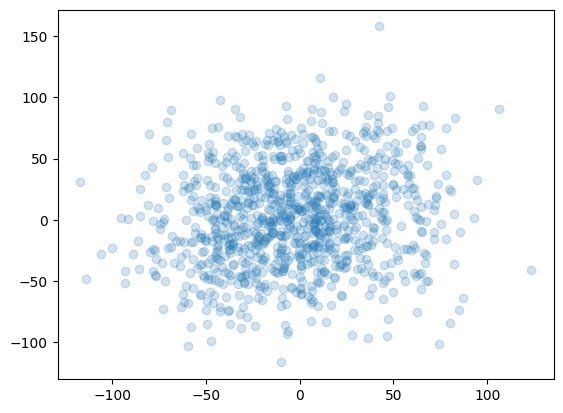

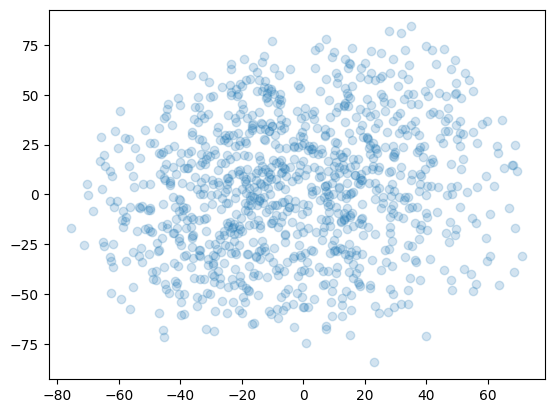

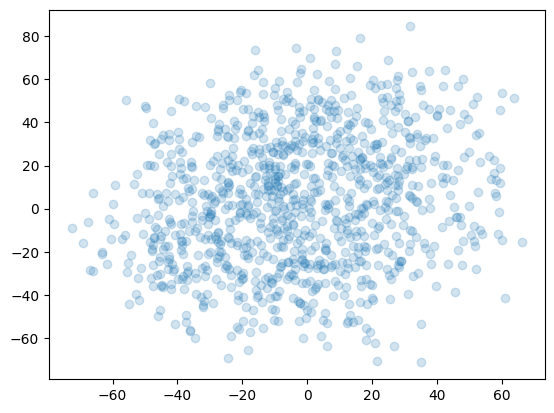

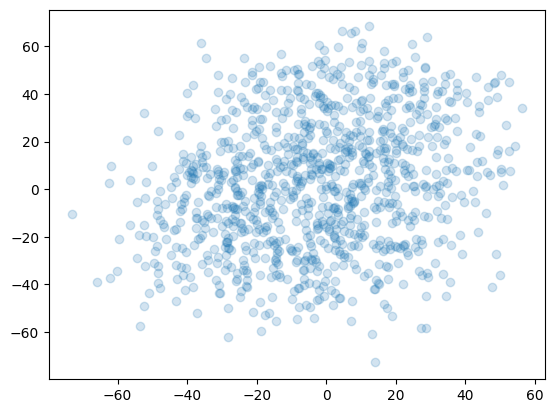

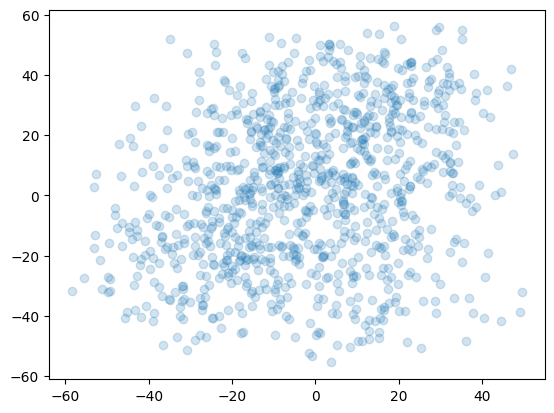

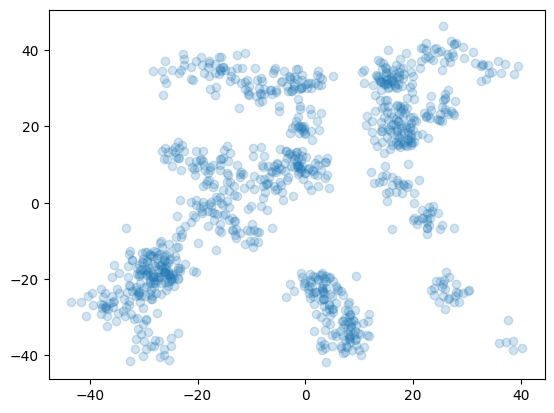

In [ ]:
for i in range(0, samples.shape[0], 199):
    # plot_dataset(samples[i])
    plt.scatter(samples[i,:,0].cpu(), samples[i,:,1].cpu(), alpha=0.2)
    plt.show()

### NLL

In [ ]:
from torch.func import jacrev

In [ ]:
mode = "follow_estimate"
reverse_time = False
normalize_data = False

In [ ]:
init_num_samples = 2048
unnorm_true_samples = target.sample(torch.tensor(init_num_samples).unsqueeze(0)).to(device).detach()

In [ ]:
def max_norm_schedule(t, max_norm):
    return 1200 * (1-t)

In [ ]:
def clip(f, max_norm, t=None):
    norm = torch.linalg.vector_norm(f, dim=-1)
    
    max_norm = max_norm_schedule(t, max_norm)
    clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
    f = f * clip_coef.unsqueeze(-1)
    return f

In [ ]:
def drift(x, t, mode="follow_estimate"):
    with torch.enable_grad():
        x.requires_grad = True

        if mode == "follow_estimate":
            f = -0.5 * noise_schedule.g(t)**2 * estimate_grad_Rt(x, t, noise_schedule, num_mc_samples=100)
            f = clip(f, max_norm=1200, t=t)

        elif mode == "follow_true":
            f = - 0.5 * noise_schedule.g(t)**2 * true_grad_Rt(x, t, noise_schedule)

        elif mode == "follow_model":
            f = - 0.5 * noise_schedule.g(t[0])**2 * vectorfield(x, t)
            f = clip(f, max_norm=2)
    return f

In [ ]:
def div_fn(u, mode="follow_estimate"):
    """Accepts a function u:R^D -> R^D."""
    J = jacrev(u)
    if mode=="follow_model":
        def div(x):
            return torch.trace(J(x.unsqueeze(0)).squeeze())
        return div
    else: 
        J = jacrev(u)
        return lambda x: torch.trace(J(x))

def output_and_div(vecfield, x, mode="follow_estimate"):
    if mode == "follow_estimate":
        dx = torch.vmap(vecfield, randomness="different")(x)
        div = torch.vmap(div_fn(vecfield, mode=mode), randomness="different")(x)
    elif mode == "follow_true":
        dx = vecfield(x)
        div = torch.vmap(div_fn(vecfield, mode=mode), randomness="different")(x.clone().detach().requires_grad_(True))
    elif mode == "follow_model":
        dx = vecfield(x)
        div = torch.vmap(div_fn(vecfield, mode=mode), randomness="different")(x)
    return dx, div

In [ ]:
def prior_dist(beta):
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(2).to(device), torch.eye(2).to(device) * beta
    )
    return dist

In [ ]:
def odefunc(t, x_in):
    x = x_in[..., :-1].clone().detach().requires_grad_(True)
    t = t.to(device)
    
    vecfield = lambda x: drift(x, t, mode=mode)
    
    if mode == "follow_model":
        def vecfield(x):
            return drift(x, torch.ones(x.shape[0]).to(device) * t, mode=mode)
    dx, div = output_and_div(vecfield, x, mode=mode)
    div = div.reshape(-1, 1)
    return torch.cat([dx, div], dim=-1)

with torch.no_grad():
    if reverse_time:
        x1 = torch.randn(1024, 2).to(device) * np.sqrt(noise_schedule.h(1))
        time = torch.linspace(1, 0, 1000).to(device)
    else:
        if normalize_data:
            x1 = true_samples
        else:
            x1 = unnorm_true_samples
        time = torch.linspace(0, 1, 1000).to(device)
    state1 = torch.cat([x1, torch.zeros_like(x1[..., :1])], dim=-1)
    state1.requires_grad = True
    states0 = odeint(odefunc, state1, t=time, method="euler")
    state0 = states0[-1]

    x0, logdetjac = state0[..., :-1], state0[..., -1]
    if normalize_data:
        x0 = unnormalize(x0, -50, 50)
        p0 = prior_dist(beta * 50**2)
    else:
        p0 = prior_dist(noise_schedule.h(1))
    logp0 = p0.log_prob(x0)
    logp1 = -(logp0 + logdetjac)

KeyboardInterrupt: 

In [ ]:
num_times = 1000
times = torch.linspace(0, 1, num_times, device=device)

lim = 100
K = 13j
y, x = np.mgrid[-lim:lim:K, -lim:lim:K]
K = int(K.imag)
zs = torch.from_numpy(np.stack([x, y], -1).reshape(K * K, 2)).to(device, torch.float32)

dydts = []
for i, t in enumerate(times):
    if reverse_time:
        dydt = odefunc(1-t, torch.cat([zs, torch.zeros_like(zs[..., :1])], dim=-1))[..., :-1]
        dydt = -dydt.cpu().detach().numpy()
    else:
        dydt = odefunc(t, torch.cat([zs, torch.zeros_like(zs[..., :1])], dim=-1))[..., :-1]
        dydt = dydt.cpu().detach().numpy()
        
    dydt = dydt.reshape(K, K, 2)
    dydts.append(dydt)
dydts = np.stack(dydts)

/tmp/ipykernel_770417/1521227777.py:20: RuntimeWarning: divide by zero encountered in log
  logmag = 2 * np.log(np.hypot(dydt[:, :, 0], dydt[:, :, 1]))


<Figure size 800x800 with 0 Axes>

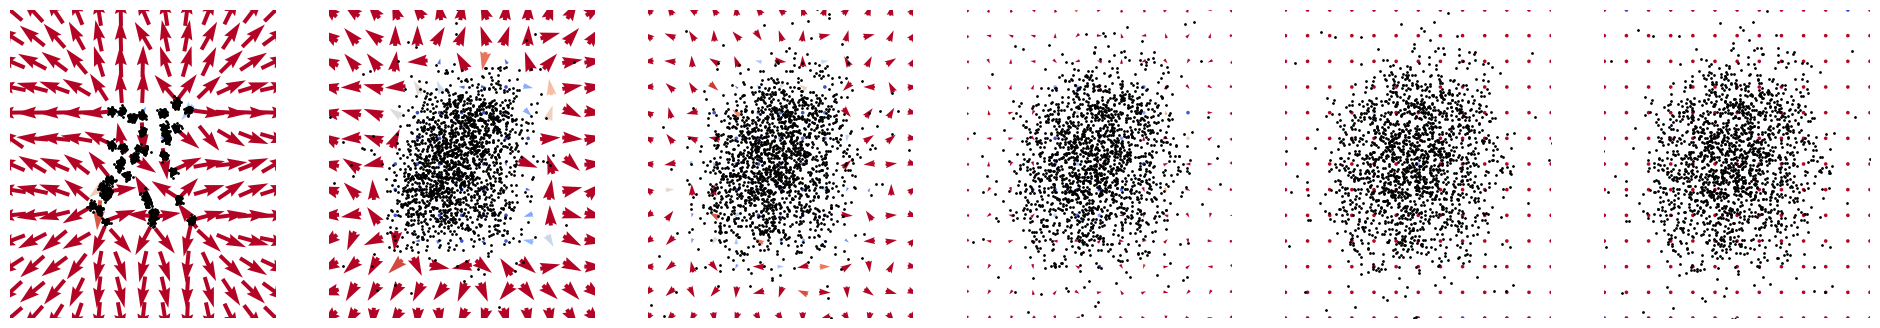

In [ ]:
plt_t_range = range(0, samples.shape[0], 199)

plt.figure(figsize=(8, 8))
fig, axes = plt.subplots(1, len(plt_t_range), figsize=(4*len(plt_t_range), 4), sharex=True, sharey=True)
axes = axes.flatten()


z_traj = states0[:,:, :-1].detach().cpu().numpy()
z_traj = z_traj[::len(z_traj)//num_times]

for i, t in enumerate(plt_t_range):
    ax = axes[i]

    # dydt = odefunc(t, torch.cat([zs, torch.zeros_like(zs[..., :1])], dim=-1))[..., :-1]
    # dydt = -dydt.cpu().detach().numpy()
    # dydt = dydt.reshape(K, K, 2)

    dydt = dydts[t]

    logmag = 2 * np.log(np.hypot(dydt[:, :, 0], dydt[:, :, 1]))
    ax.quiver(
    #x, y, dydt[:, :, 0], -dydt[:, :, 1],
        x, y, dydt[:, :, 0], dydt[:, :, 1],
    np.exp(logmag), cmap="coolwarm", scale=1e4, width=0.015, pivot="mid"
    )
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.axis("off")

    ax.scatter(z_traj[t,:,0], z_traj[t,:,1], c='k', s=1.0)
#ax.set_title("Vector Field", fontsize=32)
# t += 1

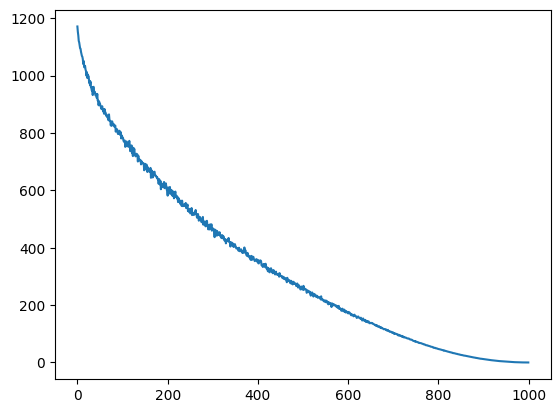

In [ ]:
plt.plot(np.linalg.norm(dydts, axis=-1).mean(axis=(1,2)))

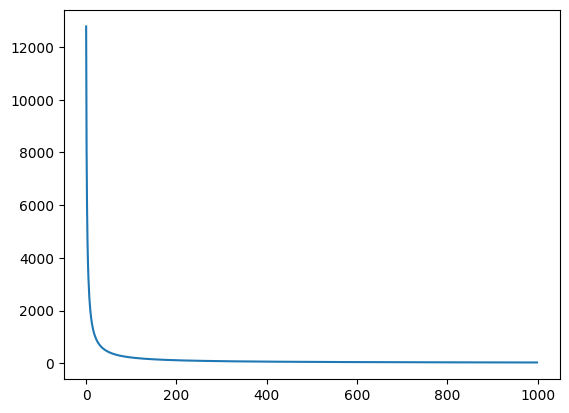

In [ ]:
plt.plot(np.linalg.norm(dydts, axis=-1).mean(axis=(1,2)))

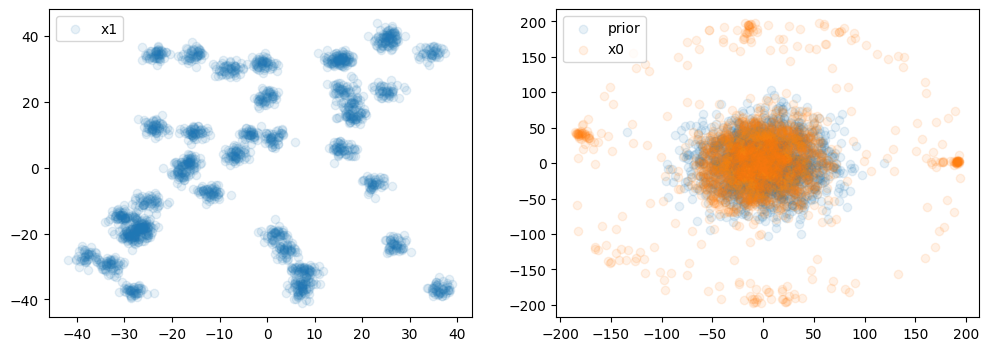

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(x1[:,0].detach().cpu(), x1[:, 1].detach().cpu(), alpha=0.1, label="x1")

prior_samples = p0.sample((2048,))
if reverse_time:
    ax[0].scatter(prior_samples[:, 0].detach().cpu(), prior_samples[:, 1].detach().cpu(), alpha=0.2, label="prior")
    # ax[1].scatter(samples[:, 0].detach().cpu(), samples[:, 1].detach().cpu(), alpha=0.1, label="generated samples")
else:
    ax[1].scatter(prior_samples[:, 0].detach().cpu(), prior_samples[:, 1].detach().cpu(), alpha=0.1, label="prior")
ax[0].legend()

ax[1].scatter(x0[:, 0].detach().cpu(), x0[:, 1].detach().cpu(), alpha=0.1, label="x0")
ax[1].legend()
# plt.xlim(-100, 100)
# plt.ylim(-100, 100)
# plt.xlim(-2, 2)
# plt.ylim(-2, 2)
plt.show()

In [ ]:
print("logp0", logp0.mean())
print("logdetjac", logdetjac.mean())
print("logp1", logp1.mean())

logp0 tensor(-9.9439, device='cuda:0')
logdetjac tensor(2.5036, device='cuda:0')
logp1 tensor(7.4402, device='cuda:0')


In [ ]:
# x0_screened = x0[(x0.abs() < 50).any(-1)
screen_indices = (x0[:,0].abs() < 100) & (x0[:,1].abs() < 100)
x0_screened = x0[screen_indices]
logdetjac_screened = logdetjac[screen_indices]
logdetjac_screened.mean()
logp0_screened = p0.log_prob(x0_screened)

logp1_screened = -(logp0_screened + logdetjac_screened)
print("logp0", logp0_screened.mean())
print("logdetjac", logdetjac_screened.mean())
print("logp1", logp1_screened.mean())

logp0 tensor(-9.8404, device='cuda:0')
logdetjac tensor(3.9299, device='cuda:0')
logp1 tensor(5.9105, device='cuda:0')


## Training a model

In [ ]:
num_epochs = 1000

noise_schedule = GeometricNoiseSchedule(0.01, 100, 1)

var_model = MyMLP(add_t_emb=False, concat_t_emb=True, input_dim=2, out_dim=2).to(device)
optim = Adam(var_model.parameters(), lr=1e-5)

# Just start with good samples since the estimated score
# already makes dope samples
x0_samples = target.sample((1024,)).to(device)
train_dataset = TensorDataset(x0_samples)
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

min_t, max_t = 0.6, 1.0

In [ ]:
all_losses = []
for epoch_num in tqdm(range(num_epochs)):
    total_loss = 0.0
    for samples in trainloader:
        samples = samples[0]
        t = ((max_t - min_t) * torch.rand(len(samples), device=device)) + min_t

        # Might need to square this
        var_loss = get_componentwise_var(
            samples,
            t,
            noise_schedule,
            var_model,
            num_outer_mc_samples=10,
            num_inner_mc_samples=10,
        )

        var_loss.backward()
        optim.step()
        optim.zero_grad()

        all_losses.append(var_loss.detach().cpu().item())

    if epoch_num % 20 == 0:
        print("Epoch %d | Loss %f" % (epoch_num, var_loss.item()))

  0%|          | 2/1000 [00:00<02:58,  5.60it/s]

Epoch 0 | Loss 62.683399


  2%|▏         | 22/1000 [00:03<02:57,  5.52it/s]

Epoch 20 | Loss 107.960846


  4%|▍         | 42/1000 [00:07<02:48,  5.68it/s]

Epoch 40 | Loss 111.605049


  6%|▌         | 62/1000 [00:11<02:47,  5.60it/s]

Epoch 60 | Loss 124.097488


  8%|▊         | 82/1000 [00:14<02:44,  5.58it/s]

Epoch 80 | Loss 58.583282


 10%|█         | 102/1000 [00:18<02:41,  5.56it/s]

Epoch 100 | Loss 155.952789


 12%|█▏        | 122/1000 [00:21<02:35,  5.63it/s]

Epoch 120 | Loss 121.225014


 14%|█▍        | 142/1000 [00:25<02:38,  5.40it/s]

Epoch 140 | Loss 138.940247


 16%|█▌        | 162/1000 [00:29<02:25,  5.75it/s]

Epoch 160 | Loss 114.880280


 18%|█▊        | 182/1000 [00:32<02:25,  5.63it/s]

Epoch 180 | Loss 50.876884


 20%|██        | 202/1000 [00:36<02:20,  5.69it/s]

Epoch 200 | Loss 41.712044


 22%|██▏       | 222/1000 [00:40<02:30,  5.16it/s]

Epoch 220 | Loss 139.798874


 24%|██▍       | 242/1000 [00:43<02:11,  5.75it/s]

Epoch 240 | Loss 58.426643


 26%|██▌       | 262/1000 [00:47<02:09,  5.69it/s]

Epoch 260 | Loss 92.159912


 28%|██▊       | 282/1000 [00:50<02:08,  5.57it/s]

Epoch 280 | Loss 54.256012


 30%|███       | 302/1000 [00:54<02:07,  5.47it/s]

Epoch 300 | Loss 112.947723


 32%|███▏      | 322/1000 [00:58<01:58,  5.72it/s]

Epoch 320 | Loss 81.133057


 34%|███▍      | 342/1000 [01:02<02:06,  5.19it/s]

Epoch 340 | Loss 54.085281


 36%|███▌      | 362/1000 [01:05<01:57,  5.41it/s]

Epoch 360 | Loss 49.806759


 38%|███▊      | 382/1000 [01:09<01:52,  5.51it/s]

Epoch 380 | Loss 80.303696


 40%|████      | 402/1000 [01:13<01:45,  5.69it/s]

Epoch 400 | Loss 102.095963


 42%|████▏     | 422/1000 [01:16<01:43,  5.56it/s]

Epoch 420 | Loss 109.393883


 44%|████▍     | 442/1000 [01:20<01:42,  5.46it/s]

Epoch 440 | Loss 128.931793


 46%|████▌     | 462/1000 [01:24<01:33,  5.77it/s]

Epoch 460 | Loss 36.252750


 48%|████▊     | 482/1000 [01:27<01:29,  5.77it/s]

Epoch 480 | Loss 64.699478


 50%|█████     | 502/1000 [01:31<01:29,  5.55it/s]

Epoch 500 | Loss 55.248207


 52%|█████▏    | 522/1000 [01:34<01:23,  5.71it/s]

Epoch 520 | Loss 76.457634


 54%|█████▍    | 542/1000 [01:38<01:21,  5.65it/s]

Epoch 540 | Loss 87.103027


 56%|█████▌    | 562/1000 [01:41<01:15,  5.79it/s]

Epoch 560 | Loss 82.564011


 58%|█████▊    | 582/1000 [01:45<01:16,  5.48it/s]

Epoch 580 | Loss 60.065811


 60%|██████    | 602/1000 [01:49<01:09,  5.75it/s]

Epoch 600 | Loss 128.448563


 62%|██████▏   | 622/1000 [01:52<01:05,  5.73it/s]

Epoch 620 | Loss 57.494675


 64%|██████▍   | 642/1000 [01:56<01:03,  5.64it/s]

Epoch 640 | Loss 126.359695


 66%|██████▌   | 662/1000 [01:59<00:57,  5.83it/s]

Epoch 660 | Loss 67.974907


 68%|██████▊   | 682/1000 [02:03<00:56,  5.62it/s]

Epoch 680 | Loss 44.495140


 70%|███████   | 702/1000 [02:07<00:57,  5.21it/s]

Epoch 700 | Loss 95.450264


 72%|███████▏  | 722/1000 [02:10<00:47,  5.88it/s]

Epoch 720 | Loss 147.545685


 74%|███████▍  | 742/1000 [02:13<00:46,  5.55it/s]

Epoch 740 | Loss 83.118721


 76%|███████▌  | 762/1000 [02:17<00:43,  5.49it/s]

Epoch 760 | Loss 107.733643


 78%|███████▊  | 782/1000 [02:21<00:38,  5.69it/s]

Epoch 780 | Loss 94.528458


 80%|████████  | 802/1000 [02:24<00:34,  5.81it/s]

Epoch 800 | Loss 40.742428


 82%|████████▏ | 821/1000 [02:28<00:32,  5.45it/s]

Epoch 820 | Loss 98.030067


 84%|████████▍ | 842/1000 [02:31<00:28,  5.62it/s]

Epoch 840 | Loss 90.592194


 86%|████████▌ | 862/1000 [02:35<00:24,  5.73it/s]

Epoch 860 | Loss 44.550114


 88%|████████▊ | 882/1000 [02:39<00:21,  5.57it/s]

Epoch 880 | Loss 134.207001


 90%|█████████ | 902/1000 [02:42<00:17,  5.54it/s]

Epoch 900 | Loss 118.027428


 92%|█████████▏| 922/1000 [02:46<00:13,  5.60it/s]

Epoch 920 | Loss 72.669502


 94%|█████████▍| 942/1000 [02:49<00:09,  5.87it/s]

Epoch 940 | Loss 77.856079


 96%|█████████▌| 962/1000 [02:53<00:06,  5.47it/s]

Epoch 960 | Loss 51.305077


 98%|█████████▊| 982/1000 [02:56<00:03,  5.58it/s]

Epoch 980 | Loss 97.578789


100%|██████████| 1000/1000 [03:00<00:00,  5.55it/s]


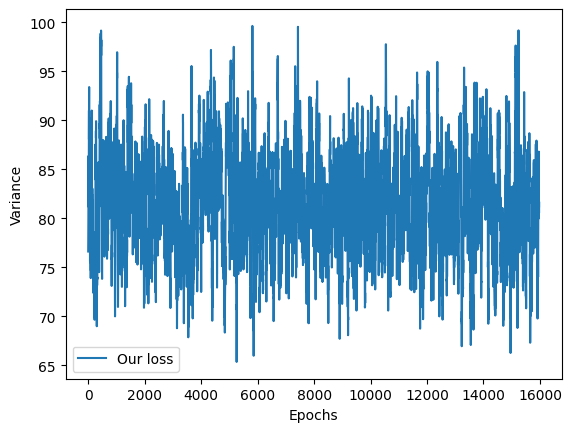

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w


plt.plot(moving_average(torch.tensor(all_losses), 30), label="Our loss")
# plt.plot(moving_average(torch.tensor(known_okay_baseline_vars), 1), label='Known okay baseline')
plt.legend()
plt.ylabel("Variance")
plt.xlabel("Epochs")
plt.show()

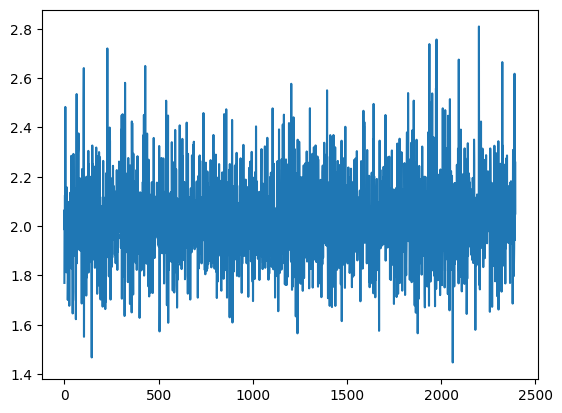

In [ ]:
plt.plot(torch.tensor(known_okay_baseline_vars) / torch.tensor(all_losses))

## Evaluating the variance

In [ ]:
import copy

AVAILABLE_LINE_STYLES = ["solid", "dashed", "dotted", (0, (1, 1))]
AVAILABLE_COLORS = ["blue", "orange", "green", "red", "black", "purple"]


def true_Rt(x, t, noise_schedule, var_exploding=True):
    h_t = noise_schedule.h(t)
    target.convolve(h_t, t, var_exploding=var_exploding)
    energy = target.log_prob(x)
    target.reset()
    return energy


def true_grad_Rt(x, t, noise_schedule, var_exploding=True):
    x.requires_grad = True
    samples_energy = true_Rt(x, t[0], noise_schedule, var_exploding=var_exploding)
    true_scores = torch.autograd.grad(samples_energy.sum(), x, retain_graph=True)[
        0
    ].detach()
    return true_scores


def plot_bias_variance_forward_trajs(
    noise_schedule,
    num_mc_samples_to_try=[100],
    num_replicates=10,
    num_points=256,
    log_scale=False,
    plot_bias=False,
    plot_variance=True,
):
    samples = target.sample((num_points,))
    times = torch.linspace(0, 1, 20, device=device)

    noisy_xs = []
    fig, ax = plt.subplots()

    for do_baseline in [False]:
        mean_bias_norms = {mc_samps: [] for mc_samps in num_mc_samples_to_try}
        mean_var_norms = copy.deepcopy(mean_bias_norms)
        mean_grad_norms = copy.deepcopy(mean_bias_norms)
        mean_baseline_var_norms = copy.deepcopy(mean_bias_norms)
        mean_baseline_bias_norms = copy.deepcopy(mean_bias_norms)
        mean_baseline_mean_adjusted_var_norms = copy.deepcopy(mean_bias_norms)
        mean_baseline_mean_adjusted_bias_norms = copy.deepcopy(mean_bias_norms)
        for t in tqdm(times, position=0, leave=True):
            h_t = noise_schedule.h(t).unsqueeze(0)

            # noisy sample: x(t)
            noisy_x = torch.normal(samples, h_t.unsqueeze(1) ** 0.5)
            noisy_xs.append(noisy_x.detach().cpu())

            true_score = true_grad_Rt(
                noisy_x.requires_grad_(), t.expand(len(noisy_x)), noise_schedule
            )

            for num_mc_samples in num_mc_samples_to_try:
                kinda_repeated_t = t.repeat(len(noisy_x))
                estimated_score = torch.cat(
                    [
                        estimate_grad_Rt(
                            noisy_x,
                            kinda_repeated_t,
                            noise_schedule,
                            var_model if do_baseline else None,
                            num_mc_samples=num_mc_samples,
                        )
                        .detach()
                        .unsqueeze(0)
                        for _ in range(num_replicates)
                    ]
                )

                repeated_x = noisy_x.unsqueeze(0).repeat_interleave(
                    num_replicates, dim=0
                )
                repeated_t = kinda_repeated_t.unsqueeze(0).repeat_interleave(
                    num_replicates, dim=0
                )

                orig_shape = copy.deepcopy(repeated_x.shape[:2])
                baseline = var_model(
                    repeated_x.flatten(0, 1),
                    # torch.cat([repeated_x, estimated_score], dim=-1).flatten(0, 1),
                    repeated_t.flatten(0, 1),
                )

                baseline = baseline.reshape(*orig_shape, -1)

                # if t > .95:
                #    import pdb; pdb.set_trace()
                mean_bias_norm = torch.linalg.vector_norm(
                    estimated_score.mean(dim=0) - true_score, dim=-1
                ).mean()

                norms = torch.linalg.vector_norm(estimated_score, dim=-1)
                mean_var_norm = norms.var(0).mean()

                baseline_score = estimated_score - baseline
                baseline_var = baseline_score.var(
                    0
                ).mean()  # torch.linalg.vector_norm(baseline_score, dim=-1).var(0).mean()

                mean_bias_norms[num_mc_samples].append(mean_bias_norm.detach().cpu())
                mean_var_norms[num_mc_samples].append(
                    estimated_score.var(0).mean().detach().cpu()
                )
                mean_grad_norms[num_mc_samples].append(norms.mean().detach().cpu())
                mean_baseline_var_norms[num_mc_samples].append(
                    baseline_var.detach().cpu()
                )

                mean_baseline_bias_norms[num_mc_samples].append(
                    torch.linalg.vector_norm(baseline_score - true_score, dim=-1)
                    .mean()
                    .detach()
                    .cpu()
                )

                adjusted_baseline_score = estimated_score - estimated_score.mean(dim=0)
                mean_baseline_mean_adjusted_var_norms[num_mc_samples].append(
                    adjusted_baseline_score.var(0).mean().detach().cpu()
                )

                mean_baseline_mean_adjusted_bias_norms[num_mc_samples].append(
                    torch.linalg.vector_norm(
                        adjusted_baseline_score - true_score, dim=-1
                    )
                    .mean()
                    .detach()
                    .cpu()
                )

        for i, num_mc_samples in enumerate(num_mc_samples_to_try):
            bias_norms = torch.tensor(mean_bias_norms[num_mc_samples])
            var_norms = torch.tensor(mean_var_norms[num_mc_samples])
            grad_norms = torch.tensor(mean_grad_norms[num_mc_samples])
            baseline_var_norms = torch.tensor(mean_baseline_var_norms[num_mc_samples])
            baseline_bias_norms = torch.tensor(mean_baseline_bias_norms[num_mc_samples])
            baseline_mean_adjusted_var_norms = torch.tensor(
                mean_baseline_mean_adjusted_var_norms[num_mc_samples]
            )
            baseline_mean_adjusted_bias_norms = torch.tensor(
                mean_baseline_mean_adjusted_bias_norms[num_mc_samples]
            )

            is_str = f'with{"" if do_baseline else "out"} learned baseline'

            if plot_bias:
                ax.plot(
                    times.cpu(),
                    bias_norms,
                    label=f"Bias {is_str} -- Num MC Samples = {num_mc_samples}",
                    linestyle=AVAILABLE_LINE_STYLES[i + int(do_baseline)],
                    c=AVAILABLE_COLORS[0],
                )

                ax.plot(
                    times.cpu(),
                    baseline_bias_norms,
                    label=f"Baseline bias {is_str} -- Num MC Samples = {num_mc_samples}",
                    linestyle=AVAILABLE_LINE_STYLES[i + int(do_baseline)],
                    c=AVAILABLE_COLORS[3],
                )

                ax.plot(
                    times.cpu(),
                    baseline_mean_adjusted_bias_norms,
                    label=f"Baseline adjusted bias {is_str} -- Num MC Samples = {num_mc_samples}",
                    linestyle=AVAILABLE_LINE_STYLES[i + int(do_baseline)],
                    c=AVAILABLE_COLORS[5],
                )

            if plot_variance:
                ax.plot(
                    times.cpu(),
                    var_norms,
                    label=f"Variance {is_str} -- Num MC Samples = {num_mc_samples}",
                    linestyle=AVAILABLE_LINE_STYLES[i + int(do_baseline)],
                    c=AVAILABLE_COLORS[1],
                )

                ax.plot(
                    times.cpu(),
                    baseline_var_norms,
                    label=f"Baseline variance {is_str} -- Num MC Samples = {num_mc_samples}",
                    linestyle=AVAILABLE_LINE_STYLES[i + int(do_baseline)],
                    c=AVAILABLE_COLORS[2],
                )

                ax.plot(
                    times.cpu(),
                    baseline_mean_adjusted_var_norms,
                    label=f"Baseline adjusted variance {is_str} -- Num MC Samples = {num_mc_samples}",
                    linestyle=AVAILABLE_LINE_STYLES[i + int(do_baseline)],
                    c=AVAILABLE_COLORS[4],
                )

    ax.set_xlabel(r"$t$")

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))
    # ax.set_xlim(0.9, 1.0)
    # ax.set_ylim(0,90)

    if log_scale:
        ax.set_yscale("log")

    ax.set_title(
        r"Bias and variance following true forward trajectories starting at $p_0$ samples"
    )
    plt.show()

    return torch.stack(noisy_xs)

100%|██████████| 20/20 [00:01<00:00, 16.72it/s]


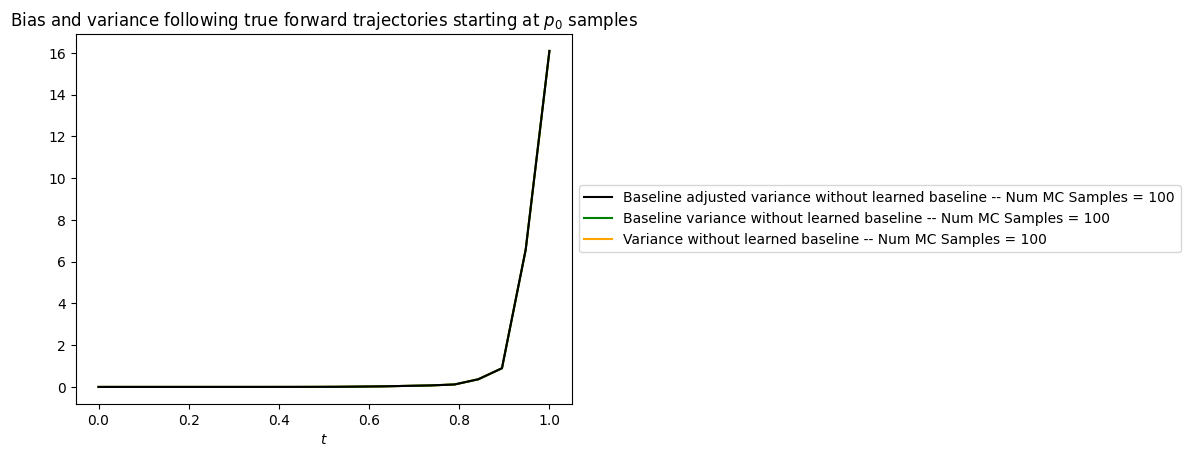

In [ ]:
noisy_xs = plot_bias_variance_forward_trajs(
    noise_schedule,
    num_mc_samples_to_try=[100],
    num_replicates=10,
    num_points=512,
    log_scale=False,
    plot_bias=False,
    plot_variance=True,
)

100%|██████████| 20/20 [00:01<00:00, 16.40it/s]


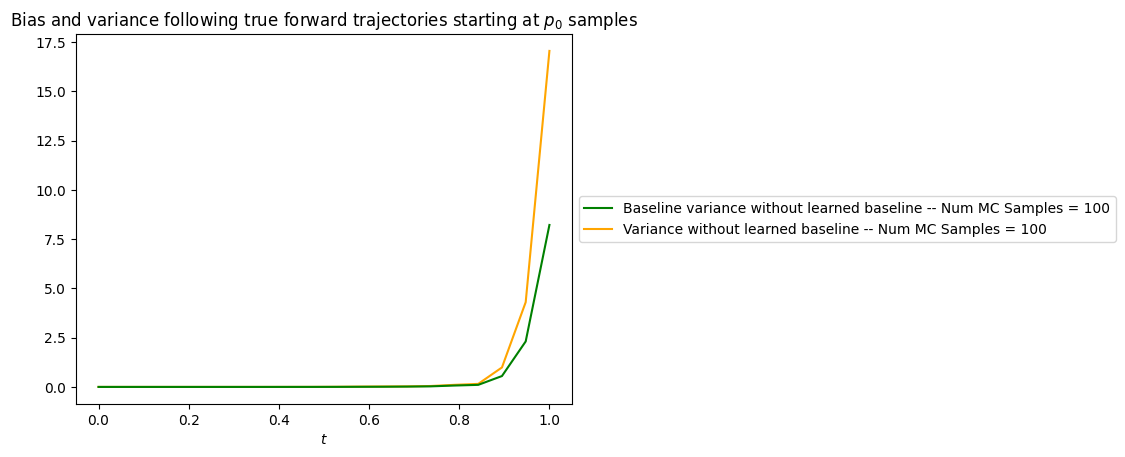

In [ ]:
noisy_xs = plot_bias_variance_forward_trajs(
    noise_schedule,
    num_mc_samples_to_try=[100],
    num_replicates=10,
    num_points=512,
    log_scale=False,
    plot_bias=False,
    plot_variance=True,
)

## Making sure the variance plot is correct

In [ ]:
import copy

AVAILABLE_LINE_STYLES = ["solid", "dashed", "dotted", (0, (1, 1))]
AVAILABLE_COLORS = ["blue", "orange", "green", "red", "black", "purple"]


def get_grad_for_var(x0, t, noise_schedule, num_mc_samples):
    h_t = noise_schedule.h(t).unsqueeze(1)

    xt = torch.normal(x0, h_t**0.5)
    return (
        estimate_grad_Rt(
            xt,
            t,
            noise_schedule,
            None,
            num_mc_samples=num_mc_samples,
        )
        .detach()
        .unsqueeze(0)
    )


def compute_covariance(repeated_scores):
    vmapped_cov = torch.vmap(torch.cov, in_dims=(0,))
    return vmapped_cov(repeated_scores.permute(1, 2, 0))


def compute_trace(cov_mtxs):
    traces = []
    for i in range(len(cov_mtxs)):
        traces.append(torch.trace(cov_mtxs[i]))

    return torch.tensor(traces)


def plot_variance_forward_trajs(
    noise_schedule,
    num_mc_samples_to_try=[100],
    num_replicates=10,
    num_points=256,
    log_scale=False,
    plot_variance=True,
):
    samples = target.sample((num_points,))
    # times = torch.tensor([0.9], device=device)
    times = torch.linspace(0, 1, 20, device=device)

    noisy_xs = []
    fig, ax = plt.subplots()

    mean_vars = {mc_samps: [] for mc_samps in num_mc_samples_to_try}
    mean_baseline_vars = copy.deepcopy(mean_vars)
    baseline_norms = copy.deepcopy(mean_vars)
    for t in tqdm(times, position=0, leave=True):
        h_t = noise_schedule.h(t).unsqueeze(0)

        for num_mc_samples in num_mc_samples_to_try:
            kinda_repeated_t = t.repeat(len(samples))

            # The first dimension is different xt ~ p_{0t}(xt | x0)
            estimated_score = torch.cat(
                [
                    get_grad_for_var(
                        samples,
                        kinda_repeated_t,
                        noise_schedule,
                        num_mc_samples=num_mc_samples,
                    )
                    for _ in range(num_replicates)
                ]
            )

            mask = (
                torch.ones_like(estimated_score)
                .unsqueeze(0)
                .repeat(num_replicates, 1, 1, 1)
            )

            idx = torch.arange(num_replicates).repeat(num_replicates)
            mask[idx, idx] = 0.0
            multd_score = estimated_score.unsqueeze(0) * mask
            baseline = -10 * multd_score.sum(dim=1) / (num_replicates - 1)

            if t > 0.9:
                import pdb

                pdb.set_trace()

            baseline_score = estimated_score - baseline

            no_baseline_covar = compute_covariance(estimated_score)
            baseline_covar = compute_covariance(baseline_score)

            trace_fxn = torch.vmap(torch.trace)
            no_baseline_trace = trace_fxn(no_baseline_covar).mean()
            baseline_trace = trace_fxn(baseline_covar).mean()

            mean_vars[num_mc_samples].append(no_baseline_trace.detach().cpu())
            mean_baseline_vars[num_mc_samples].append(baseline_trace.detach().cpu())
            baseline_norms[num_mc_samples].append(
                torch.linalg.norm(baseline, dim=-1).mean().detach().cpu()
            )

    baseline_norms = copy.deepcopy(mean_vars)
    for dict_val in [mean_vars, mean_baseline_vars, baseline_norms]:
        for num_mc_samples, pre_tnsr in dict_val.items():
            dict_val[num_mc_samples] = torch.tensor(pre_tnsr)

    for i, num_mc_samples in enumerate(num_mc_samples_to_try):
        ax.plot(
            times.cpu(),
            mean_vars[num_mc_samples],
            label=f"Variance -- Num MC Samples = {num_mc_samples}",
            linestyle=AVAILABLE_LINE_STYLES[i],
            c=AVAILABLE_COLORS[1],
        )

        ax.plot(
            times.cpu(),
            mean_baseline_vars[num_mc_samples],
            label=f"Baseline variance -- Num MC Samples = {num_mc_samples}",
            linestyle=AVAILABLE_LINE_STYLES[i],
            c=AVAILABLE_COLORS[2],
        )

    ax.set_xlabel(r"$t$")

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))
    # ax.set_xlim(0.9, 1.0)
    # ax.set_ylim(0,90)

    if log_scale:
        ax.set_yscale("log")

    ax.set_title(
        r"Bias and variance following true forward trajectories starting at $p_0$ samples"
    )
    plt.show()

    # plt.plot(times.detach().cpu(), baseline_norms[100])

 90%|█████████ | 18/20 [00:01<00:00, 16.37it/s]

> /tmp/ipykernel_33924/3606387789.py(79)plot_variance_forward_trajs()
     77                 import pdb; pdb.set_trace()
     78 
---> 79             baseline_score = estimated_score - baseline
     80 
     81             no_baseline_covar = compute_covariance(estimated_score)



ipdb>  baseline


tensor([[[ -2.4145,  -4.9199],
         [-35.8618,  17.9499],
         [ -1.1463,  -1.3787],
         ...,
         [  2.3026, -10.6975],
         [  1.6813,  -3.7772],
         [  2.4410,   2.0031]],

        [[ -4.0407,  -2.7946],
         [-43.0444,  11.0654],
         [  0.6638,  -3.3855],
         ...,
         [  3.4958, -11.2785],
         [ -0.4620,  -4.8140],
         [  2.3744,   2.7813]],

        [[ -3.7452,  -4.1372],
         [-43.3675,  10.7360],
         [ -1.6917,  -1.5586],
         ...,
         [  3.5232,  -8.4549],
         [  1.2180,  -3.7415],
         [  1.0907,   1.7595]],

        ...,

        [[ -4.3521,  -3.9492],
         [ -0.3041,  -6.4042],
         [ -2.0294,  -2.1404],
         ...,
         [  1.8481,  -9.8940],
         [  0.9416,  -4.0387],
         [  1.7450,   1.9351]],

        [[ -4.1583,  -4.1495],
         [-42.7283,  10.1384],
         [ -0.2798,  -0.1633],
         ...,
         [  3.7742, -10.9410],
         [  1.1428,  -4.1734],
         

ipdb>  estimated_score[:,0]


tensor([[ 1.5537, -0.7142],
        [ 0.0901,  1.1986],
        [ 0.3560, -0.0098],
        [-0.7210,  0.2456],
        [ 1.6434,  1.9777],
        [ 1.0670,  0.7508],
        [ 0.2191, -0.0256],
        [-0.1902,  0.1595],
        [-0.0158, -0.0208],
        [-0.2755,  0.1520]], device='cuda:0')


ipdb>  baseline[:,0]


tensor([[-2.4145, -4.9199],
        [-4.0407, -2.7946],
        [-3.7452, -4.1372],
        [-4.9419, -3.8535],
        [-2.3148, -1.9290],
        [-2.9552, -3.2922],
        [-3.8973, -4.1549],
        [-4.3521, -3.9492],
        [-4.1583, -4.1495],
        [-4.4469, -3.9575]], device='cuda:0')


 90%|█████████ | 18/20 [00:15<00:00, 16.37it/s]

ipdb>  l


     74             baseline = - 10 * multd_score.sum(dim=1) / (num_replicates - 1)
     75 
     76             if t > 0.9:
     77                 import pdb; pdb.set_trace()
     78 
---> 79             baseline_score = estimated_score - baseline
     80 
     81             no_baseline_covar = compute_covariance(estimated_score)
     82             baseline_covar = compute_covariance(baseline_score)
     83 
     84             trace_fxn = torch.vmap(torch.trace)



ipdb>  n


> /tmp/ipykernel_33924/3606387789.py(81)plot_variance_forward_trajs()
     79             baseline_score = estimated_score - baseline
     80 
---> 81             no_baseline_covar = compute_covariance(estimated_score)
     82             baseline_covar = compute_covariance(baseline_score)
     83 



ipdb>  baseline_score[:,0]


tensor([[3.9681, 4.2057],
        [4.1308, 3.9932],
        [4.1012, 4.1275],
        [4.2209, 4.0991],
        [3.9582, 3.9067],
        [4.0222, 4.0430],
        [4.1164, 4.1292],
        [4.1619, 4.1087],
        [4.1425, 4.1287],
        [4.1714, 4.1095]], device='cuda:0')


ipdb>  baseline[:,0]


tensor([[-2.4145, -4.9199],
        [-4.0407, -2.7946],
        [-3.7452, -4.1372],
        [-4.9419, -3.8535],
        [-2.3148, -1.9290],
        [-2.9552, -3.2922],
        [-3.8973, -4.1549],
        [-4.3521, -3.9492],
        [-4.1583, -4.1495],
        [-4.4469, -3.9575]], device='cuda:0')


ipdb>  estimate_score[:,0]


*** NameError: name 'estimate_score' is not defined


ipdb>  estimated_score[:,0]


tensor([[ 1.5537, -0.7142],
        [ 0.0901,  1.1986],
        [ 0.3560, -0.0098],
        [-0.7210,  0.2456],
        [ 1.6434,  1.9777],
        [ 1.0670,  0.7508],
        [ 0.2191, -0.0256],
        [-0.1902,  0.1595],
        [-0.0158, -0.0208],
        [-0.2755,  0.1520]], device='cuda:0')


ipdb>  q


 90%|█████████ | 18/20 [02:30<00:16,  8.34s/it]


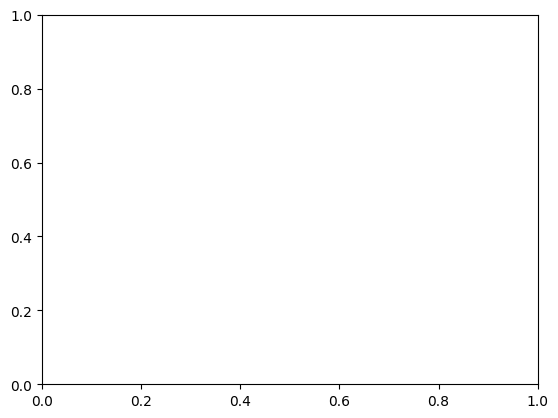

In [ ]:
plot_variance_forward_trajs(
    noise_schedule,
    num_mc_samples_to_try=[100],
    num_replicates=10,
    num_points=512,
    log_scale=False,
)

$\sum_i (x_i - \mu)^2$

$x_i' = x_i - \mu, \mu' = \frac{1}{m} \sum x_i - \mu$,

$\sum_i (x_i' - \mu')^2 = \sum (x_i - \mu - m^{-1} (\sum x_i - \mu))^2 = \sum (x_i - \mu)^2$

## Looking at the variance of $\log E_{x' \sim \mathcal{N}(x'; x_t, h(t))}[R(x')]$

In [ ]:
def plot_log_ER_variance_forward_trajs(
    noise_schedule,
    num_mc_samples_to_try=[100],
    num_replicates=10,
    num_points=256,
    log_scale=False,
    plot_variance=True,
):
    samples = target.sample((num_points,))
    # times = torch.tensor([0.9], device=device)
    times = torch.linspace(0.8, 1, 20, device=device)

    noisy_xs = []
    fig, ax = plt.subplots()

    repeated_samples = samples.unsqueeze(0).repeat_interleave(num_replicates, dim=0)

    mean_vars = {mc_samps: [] for mc_samps in num_mc_samples_to_try}
    mean_baseline_vars = copy.deepcopy(mean_vars)
    for t in tqdm(times, position=0, leave=True):
        h_t = noise_schedule.h(t).unsqueeze(0)

        for num_mc_samples in num_mc_samples_to_try:
            repeated_t = (
                t.repeat(len(samples))
                .unsqueeze(0)
                .repeat_interleave(num_replicates, dim=0)
            )
            xt = repeated_samples + (torch.randn_like(samples) * h_t.sqrt())

            vmapped_log_ER = torch.vmap(
                log_E_R, in_dims=(0, 0, None, None, None), randomness="different"
            )

            estimated_log_E_R = vmapped_log_ER(
                xt.flatten(0, 1),
                repeated_t.flatten(0, 1),
                noise_schedule,
                None,
                num_mc_samples,
            ).reshape(num_replicates, num_points, -1)

            import pdb

            pdb.set_trace()

            # The first dimension is different xt ~ p_{0t}(xt | x0)
            mask = (
                torch.ones_like(estimated_log_E_R)
                .unsqueeze(0)
                .repeat(num_replicates, 1, 1)
            )

            idx = torch.arange(num_replicates).repeat(num_replicates)
            mask[idx, idx] = 0.0
            multd_log_R = estimated_log_E_R.unsqueeze(0) * mask
            baseline = -multd_log_R.sum(dim=1) / (num_replicates - 1)

            baseline_log_E_R = estimated_log_E_R - baseline

            mean_vars[num_mc_samples].append(
                estimated_log_E_R.var(dim=0).mean().detach().cpu()
            )
            mean_baseline_vars[num_mc_samples].append(
                baseline_log_E_R.var(dim=0).mean().detach().cpu()
            )

    for dict_val in [mean_vars, mean_baseline_vars]:
        for num_mc_samples, pre_tnsr in dict_val.items():
            dict_val[num_mc_samples] = torch.tensor(pre_tnsr)

    for i, num_mc_samples in enumerate(num_mc_samples_to_try):
        ax.plot(
            times.cpu(),
            mean_vars[num_mc_samples],
            label=f"Variance -- Num MC Samples = {num_mc_samples}",
            linestyle=AVAILABLE_LINE_STYLES[i],
            c=AVAILABLE_COLORS[1],
        )

        ax.plot(
            times.cpu(),
            mean_baseline_vars[num_mc_samples],
            label=f"Baseline variance -- Num MC Samples = {num_mc_samples}",
            linestyle=AVAILABLE_LINE_STYLES[i],
            c=AVAILABLE_COLORS[2],
        )

    ax.set_xlabel(r"$t$")

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))
    # ax.set_xlim(0.9, 1.0)
    # ax.set_ylim(0,90)

    if log_scale:
        ax.set_yscale("log")

    ax.set_title(
        r"Bias and variance following true forward trajectories starting at $p_0$ samples"
    )
    plt.show()

    # plt.plot(times.detach().cpu(), baseline_norms[100])

In [ ]:
plot_log_ER_variance_forward_trajs(
    noise_schedule,
    num_mc_samples_to_try=[100],
    num_replicates=1,
    num_points=128,
    log_scale=False,
)

  0%|          | 0/20 [00:00<?, ?it/s]

> /tmp/ipykernel_33924/1795275096.py(44)plot_log_ER_variance_forward_trajs()
     42 
     43             # The first dimension is different xt ~ p_{0t}(xt | x0)
---> 44             mask = torch.ones_like(estimated_log_E_R).unsqueeze(0).repeat(
     45                 num_replicates,
     46                 1,



ipdb>  estimated_log_E_R.shape


torch.Size([1, 128, 100])


$\log E[R(x')]$

so we want

$\log Var(R(x')) = \log (E[R(x')^2] - E[R(x')]^2)$